<a href="https://colab.research.google.com/github/k4zuy/Rep-Baal-Progress/blob/main/Augmented/baal_mean_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
!git clone https://github.com/ColinS97/BaaL_Experiments.git

Cloning into 'BaaL_Experiments'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 156 (delta 92), reused 113 (delta 49), pack-reused 0
Receiving objects: 100% (156/156), 172.19 KiB | 15.65 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [120]:
cd BaaL_Experiments

/content/BaaL_Experiments/BaaL_Experiments


In [121]:
!pip install baal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.6.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [122]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Required for Nvidia RTX 3060

In [123]:
#python -m pip install torch==1.13.0+cu117 torchvision==0.14.0+cu117 -f https://download.pytorch.org/whl/torch_stable.html

Required for Colab

In [124]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
baal 1.7.0 requires matplotlib<4.0.0,>=3.4.3, but you have matplotlib 3.1.3 which is incompatible.


Imports

In [125]:
import argparse
import random
import csv
from copy import deepcopy
from time import time
import datetime
from dataclasses import dataclass
import numpy as np
import PIL
import matplotlib.pyplot as plt

import torch
import torch.backends
from torch import optim
from torch.hub import load_state_dict_from_url
from torch.nn import CrossEntropyLoss
from torchvision import datasets
from torchvision.models import vgg16
from torchvision.transforms import transforms
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F

from baal.active import get_heuristic, ActiveLearningDataset
from baal.active.active_loop import ActiveLearningLoop
from baal.bayesian.dropout import patch_module
from baal import ModelWrapper
from baal.utils.metrics import Accuracy
from baal.active.heuristics import BALD
from baal.active.dataset import ActiveLearningDataset

import aug_lib

from baal_extended.ExtendedActiveLearningDataset import ExtendedActiveLearningDataset

In [126]:
@dataclass
class ExperimentConfig:
    epoch: int = 1
    batch_size: int = 32
    initial_pool: int = 1000
    query_size: int = 100
    lr: float = 0.001
    heuristic: str = 'bald'
    iterations: int = 40
    training_duration: int = 10

In [127]:
def get_datasets(initial_pool, n_augmentations):
    transform = transforms.Compose(
        [
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    aug_transform = transforms.Compose(
        [
            # transforms.Resize((224, 224)),
            aug_lib.TrivialAugment(),
            transforms.ToTensor(),
            #transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    test_transform = transforms.Compose(
        [
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    # Note: We use the test set here as an example. You should make your own validation set.
    train_ds = datasets.CIFAR10(
        ".", train=True, transform=transform, target_transform=None, download=True
    )

    aug_train_ds = datasets.CIFAR10(
        ".", train=True, transform=aug_transform, target_transform=None, download=True
    )
    test_set = datasets.CIFAR10(
        ".", train=False, transform=test_transform, target_transform=None, download=True
    )
    eald_set = ExtendedActiveLearningDataset(train_ds)

    # active_set = ActiveLearningDataset(
    #    train_ds, pool_specifics={"transform": test_transform}
    # )
    eald_set.augment_n_times(n_augmentations, augmented_dataset=aug_train_ds)
    # We start labeling randomly.
    eald_set.label_randomly(initial_pool)
    return eald_set, test_set

In [128]:
hyperparams = ExperimentConfig()
use_cuda = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True
random.seed(1337)
torch.manual_seed(1337)
if not use_cuda:
    print("warning, the experiments would take ages to run on cpu")

# Get datasets
active_set, test_set = get_datasets(hyperparams.initial_pool,2)

# Get our model.
heuristic = get_heuristic(hyperparams.heuristic)
criterion = CrossEntropyLoss()
model = vgg16(num_classes=10)

# change dropout layer to MCDropout
model = patch_module(model)

if use_cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=hyperparams.lr, momentum=0.9)

# Wraps the model into a usable API.
model = ModelWrapper(model, criterion)

# for ActiveLearningLoop we use a smaller batchsize
# since we will stack predictions to perform MCDropout.
active_loop = ActiveLearningLoop(active_set,
                                 model.predict_on_dataset,
                                 heuristic,
                                 hyperparams.query_size,
                                 batch_size=1,
                                 iterations=hyperparams.iterations,
                                 use_cuda=use_cuda,
                                 verbose=False)

# We will reset the weights at each active learning step so we make a copy.
init_weights = deepcopy(model.state_dict())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
Files already downloaded and verified
orig len50000
augmented n times0


In [129]:
for epoch in tqdm(range(hyperparams.epoch)):
            # if we are in the last round we want to train for longer epochs to get a more comparable result
            #if epoch == args.epoch:
             #   hyperparams["learning_epoch"] = 75
            
            # Load the initial weights.
            
            model.load_state_dict(init_weights)
            model.train_on_dataset(
                active_set,
                optimizer,
                hyperparams.batch_size,
                hyperparams.training_duration,
                use_cuda,
            )

            # Validation!
            
            model.test_on_dataset(test_set, hyperparams.batch_size, use_cuda)
            metrics = model.metrics
            

  0%|          | 0/1 [00:00<?, ?it/s]

[72-MainThread   ] [baal.modelwrapper:train_on_dataset:83] 2022-12-11T18:13:03.625554Z [info     ] Starting training              dataset=3000 epoch=10


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[72-MainThread   ] [baal.modelwrapper:train_on_dataset:94] 2022-12-11T18:30:57.181002Z [info     ] Training complete              train_loss=2.133826971054077
[72-MainThread   ] [baal.modelwrapper:test_on_dataset:123] 2022-12-11T18:30:57.188306Z [info     ] Starting evaluating            dataset=10000
[72-MainThread   ] [baal.modelwrapper:test_on_dataset:133] 2022-12-11T18:31:00.688699Z [info     ] Evaluation complete            test_loss=2.1083219051361084


100%|██████████| 1/1 [17:57<00:00, 1077.11s/it]


In [131]:
orgset_len = int(len(active_set._dataset)/(3)) # length of original dataset (dataset divided through amount augmentatios + 1)
print("orgset_len: " + str(orgset_len))
pool = active_set.pool
if len(pool) > 0:
    indices = np.arange(len(pool)) # array von 0 bis len(pool)-1 (nach initial label: 146999)
    probs = model.predict_on_dataset(pool,batch_size=10,iterations=hyperparams.iterations,use_cuda=use_cuda)
    #if probs is not None and (isinstance(probs, types.GeneratorType) or len(probs) > 0):
    # -> "isinstance(...) needed when using predict_..._Generator"
    if probs is not None and len(probs) > 0:
        #to_label, uncertainties = heuristic.get_ranks(probs) 
        _, uncertainties = heuristic.get_ranks(probs)
            # to_label -> indices sortiert von größter zu niedrigster uncertainty
            # uncertainty -> alle uncertainties des pools in Reihenfolge wie pool vorliegt
            #to_label = indices[np.array(to_label)] # was hier passiert keine Ahnung aber to_label bleibt gleich also unnütze Zeile?
        # 1. get all original images from to_label(whole pool sorted after uncertainties highest to lowest)
        # 2. get for each original image the ids of augmented children and all three uncertainties
        # 3. calculate the means
        # 4. sort those means after highest to lowest uncertainties 
        # 5. label images (all of one kind) after query value with pool indices
        trios = []
        oracle_idx = active_set._pool_to_oracle_index(indices)
        for idx in oracle_idx:   
            # checks if img already in trios
            if idx not in trios:
                if idx >= orgset_len and idx < len(active_set._dataset)-orgset_len:
                    # img is first augmentation
                    org = idx - orgset_len
                    aug1 = idx
                    aug2 = idx + orgset_len
                elif idx >= len(active_set._dataset)-orgset_len:
                    # img is second augmentation
                    org = idx - 2*orgset_len
                    aug1 = idx - orgset_len
                    aug2 = idx
                else:
                    # img is original 
                    org = idx
                    aug1 = idx + orgset_len
                    aug2 = idx + 2*orgset_len
                #trio = (org, aug1, aug2)
                #trios.append(trio)
                trios.append(int(org))
                trios.append(int(aug1))
                trios.append(int(aug2))
        print("trios: " + str(trios))
        #trios = (np.asarray(trios,"int")).tolist()
        trios_uncertainties = []
        pool_trios = active_set._oracle_to_pool_index(trios)
        for i in range(len(pool_trios)):
            # get the uncertainty of all images
            trios_uncertainties.append(uncertainties[pool_trios[i]])
        trios_mean = []
        k = trios_uncertainties[0]
        assert len(trios_uncertainties) % 3 == 0, "trios_mean should be a multiple of augmentations + 1"
        for i in range(1,len(trios_uncertainties)):
            if (i+1) % 3 != 0:
                k += trios_uncertainties[i]
            else:
                k += trios_uncertainties[i]
                mean = k/3
                trios_mean.append(mean)
                k = 0
        trios_idx_mean_sorted = np.argsort(trios_mean)[::-1]
        to_label = []
        for idx in trios_idx_mean_sorted:
            # org image will be chosen
            to_label.append(pool_trios[3*idx])
        # original and all augmentations will be labled

       # active_set.label(to_label[: hyperparams.query_size])
    else:
        print("break")
        #break
else: 
    print("break")
    #break

orgset_len: 50000.0
[72-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:232] 2022-12-11T18:31:30.530962Z [info     ] Start Predict                  dataset=147000
100%|██████████| 14700/14700 [20:24<00:00, 12.00it/s]
trios: [0, 50000, 100000, 1, 50001, 100001, 2, 50002, 100002, 3, 50003, 100003, 4, 50004, 100004, 5, 50005, 100005, 6, 50006, 100006, 7, 50007, 100007, 8, 50008, 100008, 9, 50009, 100009, 10, 50010, 100010, 11, 50011, 100011, 12, 50012, 100012, 13, 50013, 100013, 14, 50014, 100014, 15, 50015, 100015, 16, 50016, 100016, 17, 50017, 100017, 18, 50018, 100018, 19, 50019, 100019, 20, 50020, 100020, 21, 50021, 100021, 22, 50022, 100022, 24, 50024, 100024, 25, 50025, 100025, 26, 50026, 100026, 27, 50027, 100027, 28, 50028, 100028, 29, 50029, 100029, 30, 50030, 100030, 31, 50031, 100031, 32, 50032, 100032, 33, 50033, 100033, 34, 50034, 100034, 35, 50035, 100035, 36, 50036, 100036, 37, 50037, 100037, 38, 50038, 100038, 39, 50039, 100039, 40, 50040, 100040, 41, 50041,

In [138]:
len(oracle_idx)

147000

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [135]:
len(active_set._dataset)

150000

In [132]:
len(trios)

149919

In [136]:
len(pool_trios)

149919

In [82]:
trios_idx_mean_sorted[:10]

array([42313, 43139, 38030,  3277, 25299, 35124, 42488, 30738,  8861,
        6217])

In [92]:
max_mean_idx = trios_idx_mean_sorted[0]
max_mean_idx

42313

In [99]:
max_mean = trios_mean[max_mean_idx]
assert max_mean == max(trios_mean), "Error"
max_mean

0.034551660219828285

In [87]:
to_label[:10]

[43277, 44120, 38912, 3354, 25884, 35939, 43455, 31448, 9073, 6357]

In [109]:
org_img = trios_uncertainties[3*max_mean_idx]
aug1_img =  trios_uncertainties[(3*max_mean_idx)+1]
aug2_img =  trios_uncertainties[(3*max_mean_idx)+2]
org_img_idx = pool_trios[3*max_mean_idx]
aug1_img_idx =  pool_trios[(3*max_mean_idx)+1]
aug2_img_idx =  pool_trios[(3*max_mean_idx)+2]
print(f"idx: {org_img_idx}, {aug1_img_idx}, {aug2_img_idx}")
print(f"values: {org_img}, {aug1_img}, {aug2_img}")
man_mean = (org_img+aug1_img+aug2_img)/3
print(f"mean: {man_mean}")

idx: 42313, 91202, 140102
values: 0.040949463844299316, 0.028479576110839844, 0.0342259407043457
mean: 0.034551660219828285


In [62]:
for i in range(len(oracle_idx)):
  if oracle_idx[i] != i:
    print(f"i: {i}, v: {oracle_idx[i]}")
    break

oracle_idx[50:60]

i: 56, v: 57


[50, 51, 52, 53, 54, 55, 57, 58, 59, 60]

In [57]:
len(oracle_idx)

147000

In [50]:
a = [4.9,7.0]
print(type(a))
b = (np.asarray(a,"int")).tolist()
b

<class 'list'>


[4, 7]

In [ ]:
print(active_set.n_labelled)
print(active_set.n_unlabelled)

3000
147000


In [ ]:
pool = active_set.pool
indices = np.arange(len(pool))
indices

array([     0,      1,      2, ..., 146997, 146998, 146999])

In [ ]:
probs = model.predict_on_dataset(pool,batch_size=10,iterations=20,use_cuda=use_cuda)

[73-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:263] 2022-11-30T14:45:34.712685Z [info     ] Start Predict                  dataset=147000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 14700/14700 [10:15<00:00, 23.88it/s]


In [ ]:
to_label, uncertainty = heuristic.get_ranks(probs) 
to_label = indices[np.array(to_label)]

In [ ]:
print(uncertainty)
print(to_label)

[4.2915344e-05 8.4877014e-05 7.4863434e-05 ... 6.9141388e-05 3.4332275e-05
 6.4611435e-05]
[ 81371  56391 111414 ...  92760 125902  60189]


In [ ]:
# größte uncertainty 
# (ix_global_img sowieso in to_label[0] aber for-Schleife für besseres Verständnis)
# also to_label[0] == uncertainty[ix_global_img]
u = 0
ix_pool_img = 0
for i in range(len(uncertainty)):
  if(uncertainty[i]>u): 
    u = uncertainty[i]
    ix_pool_img = i

print("größte uncertainty: " + str(u))
print("dazugehöriger Index: " + str(ix_pool_img))

größte uncertainty: 0.00020480156
dazugehöriger Index: 81371


In [ ]:
# größter index
l = 0
for i in range(len(to_label)):
  if(to_label[i]>l): l = to_label[i]

l

146999

In [ ]:
oracle_set_one = active_set._pool_to_oracle_index([104559])
print(oracle_set_one)
oracle_set_two = active_set._pool_to_oracle_index(to_label)
print(oracle_set_two[0])
#ix_global_img = oracle_set[0]
#ix_global_img


[106677]
83028


In [ ]:
oracle_set = active_set._pool_to_oracle_index(to_label)
ix_global_img = oracle_set[5]
ix_pool_img = to_label[5]

In [ ]:
pool_img = active_set.pool[ix_pool_img]
global_img = active_set._dataset[ix_global_img]
#global_img = active_set._dataset[ix_global_img]

In [ ]:
print(pool_img)

(tensor([[[0.9647, 0.9608, 0.9647,  ..., 0.9686, 0.9686, 0.9647],
         [0.9765, 0.9686, 0.9725,  ..., 0.9765, 0.9765, 0.9725],
         [0.9686, 0.9647, 0.9686,  ..., 0.9686, 0.9686, 0.9686],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1

In [ ]:
tensors_global = []
tensors_pool = []

for i in range(2):
  pool_img = active_set.pool[ix_pool_img]
  global_img = active_set._dataset[ix_global_img]
  tensors_pool.append(pool_img)
  tensors_global.append(global_img)


print(torch.eq(tensors_pool[0][0],tensors_pool[1][0]))
print(torch.eq(tensors_global[0][0],tensors_global[1][0]))

tensor([[[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         ...,
         [ True, False,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         ...,
         [ True, False,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         ...,
         [ True, False,  True,  ..., False, False, False],
         [

In [ ]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        #axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Bilder mit Normalisierung -> verzerrte Farben

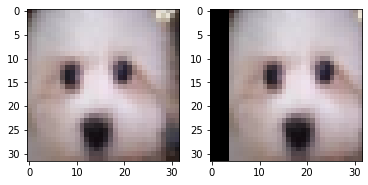

In [ ]:
show((pool_img[0],global_img[0]))

In [ ]:
torch.eq(global_img[0],pool_img[0])

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True, False, False,  ..., False, False, False],
         ...,
         [ True, False, False,  ..., False, False, False],
         [

In [ ]:
compare = torch.eq(global_img[0],pool_img[0])

for i in range(0,2):
  for l in range(0,31):
    for k in range(0,31):
      if compare[i][l][k] == False:
        print(f"compare[{i}][{l}][{k}]")

In [ ]:
torch.abs(global_img[0] - pool_img[0])

tensor([[[0.0275, 0.0275, 0.0275,  ..., 0.0235, 0.0235, 0.0275],
         [0.0275, 0.0275, 0.0275,  ..., 0.0235, 0.0235, 0.0275],
         [0.0275, 0.0235, 0.0275,  ..., 0.0196, 0.0196, 0.0235],
         ...,
         [0.0196, 0.0157, 0.0196,  ..., 0.0235, 0.0235, 0.0235],
         [0.0196, 0.0196, 0.0196,  ..., 0.0235, 0.0235, 0.0235],
         [0.0157, 0.0157, 0.0157,  ..., 0.0235, 0.0235, 0.0235]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0039, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0118, 0.0078,  ..., 0.0118, 0.0118, 0.0078],
         ...,
         [0.0039, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
         [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0078, 0.0039,  ..., 0.0118, 0.0118, 0.

Normalisierung umgekehrt

In [ ]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],std = [ 1., 1., 1. ]),
                               ])

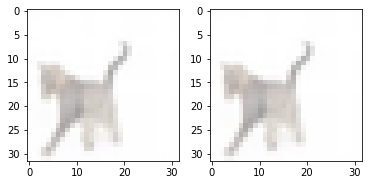

In [ ]:
show((invTrans(pool_img[0]),invTrans(global_img[0])))

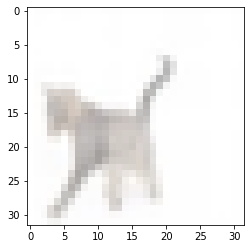

In [ ]:
plt.imshow(invTrans(pool_img[0]).permute(1, 2, 0).numpy())

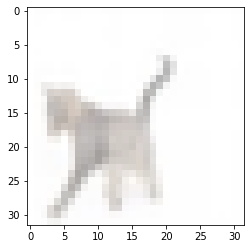

In [ ]:
plt.imshow(invTrans(global_img[0]).permute(1, 2, 0).numpy())

In [ ]:
torch.eq(invTrans(pool_img[0]),invTrans(global_img[0]))

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

In [ ]:
torch.abs(invTrans(pool_img[0]) - invTrans(global_img[0]))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

Versuche herauszufinden was folgende Zeile genau macht und wieso aber bisher erfolglos

In [ ]:
to_label_two = indices[np.array(to_label)]
to_label_two

array([ 81371,  56391, 111414, ...,  92760, 125902,  60189])

In [ ]:
print(type(to_label))
print(type(to_label_two))
print(len(to_label))
print(len(to_label_two))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
147000
147000


In [ ]:
indices[np.array(to_label)]

array([ 81371,  56391, 111414, ...,  92760, 125902,  60189])

In [ ]:
t = np.array([3,7,1,4])
t

array([3, 7, 1, 4])